# Optimal transport distance between 2D densities 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.linalg import solve
from PIL import Image as im
from scipy.integrate import simps
from scipy.sparse import diags, csr_matrix, eye, kron, lil_matrix, coo_matrix, vstack, hstack
from scipy.sparse.linalg import spsolve

In [3]:
m, n = 256, 256

lin = np.linspace(0, m-1, m)

image1 = np.meshgrid(lin, lin)[0]
image2 = np.ones((n, n))

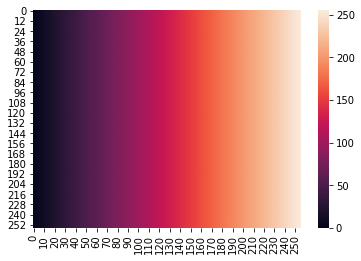

In [4]:
sns.heatmap(image1)
plt.show()

## Create meshgrid for domain $[0,1] \times [0,1]$

In [5]:
def _meshgrid(density):
    m = density.shape[1]
    x = np.linspace(0, 1, m)
    x1, x2 = np.meshgrid(x, x, indexing='xy')
    return x1, np.flipud(x2)  

## Normalise densities such that $\int f(x) dx = \int g(y) dy = 1$

Also add a small constant $\epsilon$ to ensure densities are non-zero

In [6]:
def _normalise(density, eps):
    x = np.linspace(0, 1, density.shape[1])
    return (density + eps) / float(simps(simps(density + eps, x), x))

# Gradient operators

In [7]:
def _dx(m):
    diagonals = [np.ones(m-1), -np.ones(m-1)]
    diagonals1 = [np.ones(m-1), -2*np.ones(m), np.ones(m-1)]
    dx = diags(diagonals, [-1, 1]).toarray()
    dxx = diags(diagonals1, [-1, 0, 1]).toarray()
    dx[0,1], dx[-1,-2] = 0, 0       
    dxx[0,1], dxx[-1,-2] = 2, 2
    return csr_matrix(-dx), csr_matrix(dxx)

def _derivative_matrices(m):
    dx1 = kron(_dx(m)[0], eye(m))
    dx2 = -kron(eye(m), _dx(m)[0])
    d2x1 = kron(_dx(m)[1], eye(m))
    d2x2 = kron(eye(m), _dx(m)[1])
    dx1x2 = -kron(_dx(m)[0], _dx(m)[0])   
    return dx1, dx2, d2x1, d2x2, dx1x2

def _helpers(m):
    diagonals = np.ones(m-1)
    right = diags(diagonals, 1).toarray()
    left = diags(diagonals, -1).toarray()
    right[0,1] = 2
    left[-1, -2] = 2
    return csr_matrix(right), csr_matrix(left)

In [31]:
m, n = 256, 256

lin = np.linspace(0, m-1, n)

image1 = np.fliplr(np.meshgrid(lin, lin)[0])
image2 = np.ones((m, n))

m, n = image1.shape
h, k = 1./(m-1), 1./(n-1)

# Generate domain    

x1, x2 = _meshgrid(image1)

# Normalise densities s.t. \int f(x)dx = \int g(y)dy = 1

f_x, g_y = _normalise(image1, 1), _normalise(image2, 1)

g_y1, g_y2 = np.gradient(g_y)

dx1, dx2, d2x1, d2x2, dx1x2 = _derivative_matrices(m)

R, L = _helpers(m)

# Iteratively solve to find u(x1, x2) using Newton's method until error < tolerance

d1, d2, d3, d4 = lil_matrix((m**2, n**2)), lil_matrix((m**2, n**2)), lil_matrix((m**2, n**2)), lil_matrix((m**2, n**2))

error = 1
iters = 1
max_iters = 5
dampening = 1
tol = 1e-5
u = np.zeros((m**2, 1))

In [32]:
while error > tol and iters < max_iters:
    ux1, ux2 = dx1*u/(2.*h), dx2*u/(2.*k)
    ux1x1, ux2x2, ux1x2 = d2x1*u/(h**2), d2x2*u/(k**2), dx1x2*u/(4*h*k)

    ux1, ux2 = np.reshape(ux1, (m, n)), np.reshape(ux2, (m, n))

# Check error:

    x_ux1, x_ux2 = x1 - ux1, x2 - ux2

    residual = ((1-ux1x1)*(1-ux2x2) - ux1x2**2) * np.reshape(np.ndarray.flatten(g_y, 'F'), (m*n, 1)) \
    - np.reshape(np.ndarray.flatten(f_x, 'F'), (m*n, 1));
    error = np.abs(np.max(residual) - np.min(residual))
    print(error)
    if error < tol:
        print('Solution converged')

# find g_y1, g_y2 and evaluate at         

    G = np.reshape(np.ndarray.flatten(g_y[(k*(1 - x_ux2)).astype(int), (k*x_ux1).astype(int)], 'F'), (m*n, 1))
    G_y1 = np.reshape(np.ndarray.flatten(g_y1[(k*(1 - x_ux2)).astype(int), (k*x_ux1).astype(int)], 'F'), (m*n, 1))
    G_y2 = np.reshape(np.ndarray.flatten(g_y2[(k*(1 - x_ux2)).astype(int), (k*x_ux1).astype(int)], 'F'), (m*n, 1))

# Paper coefficients

    A =  1 - ux1x1 - ux2x2 - ux1x2**2 + ux1x1*ux2x2 
    B =  ux2x2 - 1
    C =  ux1x1 - 1
    D = -2*ux1x2

# Set up system of equations
    print(1)
    d1.setdiag(B*G/h**2 - A*G_y1/(2*h))
    d2.setdiag(C*G/k**2 - A*G_y2/(2*k))
    d3.setdiag(-2*G*(B/h**2 + C/k**2))
    d4.setdiag(G*D/(4*h*k))
    
    W = eye(m*n) * d3 + kron(eye(m), R) * d1 + kron(eye(m), L) * d1 + \
    kron(R, eye(n)) * d2 + kron(L, eye(n)) * d2 + -dx1x2 * d4

# Add additional constraint for deterministic system 

    pad1 = csr_matrix(np.ones((1,n**2)))
    pad2 = np.ones((m**2 + 1, 1))
    pad2[-1] = 0
    pad2 = csr_matrix(pad2)
    
    W = vstack((W, pad1))
    W = hstack((W, pad2))
    W = csr_matrix(W)
    print(2)
# Right-hand side                        
                             
    b = np.reshape(np.ndarray.flatten(f_x, 'F'), (m*n, 1)) - G*A
    b = np.vstack((b,0))
    b = csr_matrix(b)


# solve the system                          
    print(3)
    ew = spsolve(W, b)  
    print(4)
# Update solution and repeat

    u = u + np.reshape(ew[:-1], (n*m, 1))

    iters += 1
    
# Compute Wasserstein metric

# Optimal mapping is s(x) = x - u_x(x), plotted with mesh generation 



1.98443579767
1
2
3
4
5.80526737792e-11
Solution converged
1
2
3
4


In [33]:
u.shape

(65536, 1)

In [40]:
mapping = (np.rot90(np.reshape(u, (m,n))))

ux1, ux2 = np.gradient(mapping)

c = (ux1**2 + ux2**2) * image1

s_x1, s_x2 = x1 - ux1, x2 - ux2

x = np.linspace(0, 1, m)

cost = np.sqrt(simps(simps(c, x), x))
cost

0.0080216089863209879

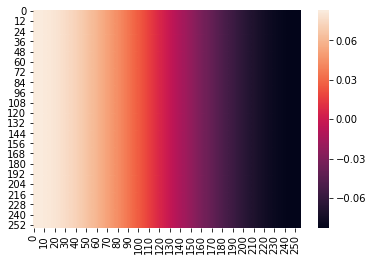

In [41]:
sns.heatmap(mapping)
plt.show()

In [59]:
cost

0.49935146667545904

In [393]:
def _optimaltransport(image1, image2, eps, max_iters, tol, damp, plotting=0):
    
    m, n = image1.shape
    h, k = 1./(m-1), 1./(n-1)
    
# Generate domain    
    
    x1, x2 = _meshgrid(source)
    
# Normalise densities s.t. \int f(x)dx = \int g(y)dy = 1
    
    f_x, g_y = _normalise(image1, 1), _normalise(image2, 1)
    
    g_y1, g_y2 = np.gradient(g_y)
    
    dx1, dx2, d2x1, d2x2, dx1x2 = _derivative_matrices(m)

# Iteratively solve to find u(x1, x2) using Newton's method until error < tolerance
    
    d1, d2, d3, d4 = lil_matrix((m**2, n**2)), lil_matrix((m**2, n**2)), lil_matrix((m**2, n**2)), lil_matrix((m**2, n**2))
    
    error = 1
    iters = 1
    u = np.zeros((m**2, 1))
    
    while error > tol and iters < max_iters:
        ux1, ux2 = dx1*u/(2.*h), dx2*u/(2.*k)
        ux1x1, ux2x2, ux1x2 = d2x1*u/(h**2), d2x2*u/(k**2), dx1x2*u/(4*h*k)

        ux1, ux2 = np.reshape(ux1, (m, n)), np.reshape(ux2, (m, n))

# Check error:

        x_ux1, x_ux2 = x1 - ux1, x2 - ux2

        residual = ((1-ux1x1)*(1-ux2x2) - ux1x2**2)*np.ndarray.flatten(g_y, 'F') - np.reshape(np.ndarray.flatten(f_x, 'F'), (m*n, 1))
        error = abs(np.max(residual).all() - np.min(residual).all())

# find g_y1, g_y2 and evaluate at         

        G = np.reshape(np.ndarray.flatten(g_y[(k*(1 - x_ux2)).astype(int), (k*x_ux1).astype(int)], 'F'), (m*n, 1))
        G_y1 = np.reshape(np.ndarray.flatten(g_y1[(k*(1 - x_ux2)).astype(int), (k*x_ux1).astype(int)], 'F'), (m*n, 1))
        G_y2 = np.reshape(np.ndarray.flatten(g_y2[(k*(1 - x_ux2)).astype(int), (k*x_ux1).astype(int)], 'F'), (m*n, 1))

# Paper coefficients

        A =  1 - ux1x1 - ux2x2 - ux1x2**2 + ux1x1*ux2x2 
        B =  ux2x2 - 1
        C =  ux1x1 - 1
        D = -2*ux1x2

# Set up system of equations

        d1.setdiag(B*G/h**2 - A*G_y1/(2*h))
        d2.setdiag(C*G/k**2 - A*G_y2/(2*k))
        d3.setdiag(-2*G*(B/h**2 + C/k**2))
        d4.setdiag(G*D/(4*h*k))

        W = eye(m*n) * d3 + kron(eye(m), R) * d1 + kron(eye(m), L) * d1 + \
        kron(R, eye(n)) * d2 + kron(L, eye(n)) * d2 + -dx1x2 * d4

# Add additional constraint for deterministic system 

        pad1 = csr_matrix(np.ones((1,n**2)))
        pad2 = np.ones((m**2 + 1, 1))
        pad2[-1] = 0
        pad2 = csr_matrix(pad2)

        W = vstack((W, pad1))
        W = hstack((W, pad2))
        W = csr_matrix(W)

# Right-hand side                        

        b = np.reshape(np.ndarray.flatten(f_x, 'F'), (m*n, 1)) - G*A
        b = np.vstack((b,0))
        b = csr_matrix(b)


# solve the system                          

        ew = spsolve(W, b)  

# Update solution and repeat

        u = u + np.reshape(ew[:-1], (n*m, 1))

        iters += 1

# Compute Wasserstein metric

# Optimal mapping is s(x) = x - u_x(x), plotted with mesh generation 
        
    u = np.shape(u, (m, n))

# compute Wasserstein metric

    u = np.rot90(np.reshape(u, (m,n)))

    ux1, ux2 = np.gradient(u)

    c = (ux1**2 + ux2**2) * image1

    x = np.linspace(0, 1, m)

    cost = np.sqrt(simps(simps(c, x), x))
    cost

# optimal mapping 

    s_x1, s_x2 = x1 - ux1, x2 - ux2

In [274]:
class OptimalTransport():
    
    def __init__(self, image1, image2, tol, max_iters, eps):
        self.image1 = image1
        self.image2 = image2
        self.tol = tol
        self.max_iters = max_iters
        self.eps = eps
        
    def _meshgrid(self, m):
        x = np.linspace(0, 1, m)
        x1, x2 = np.meshgrid(x, x, indexing='xy')
        return x1, np.flipud(x2) 
    
    def _normalise(self, image, m):
        x = np.linspace(0, 1, m)
        return (image + self.eps) / float(simps(simps(image + self.eps, x), x))
    
    def _dx(m):
        diagonals = [np.ones(m-1), -np.ones(m-1)]
        diagonals1 = [np.ones(m-1), -2*np.ones(m), np.ones(m-1)]
        dx = diags(diagonals, [-1, 1]).toarray()
        dxx = diags(diagonals1, [-1, 0, 1]).toarray()
        dx[0,1], dx[-1,-2] = 0, 0       
        dxx[0,1], dxx[-1,-2] = 2, 2
        return csr_matrix(-dx), csr_matrix(dxx)

    def _derivative_matrices(m):
        dx1 = kron(_dx(m)[0], eye(m))
        dx2 = -kron(eye(m), _dx(m)[0])
        d2x1 = kron(_dx(m)[1], eye(m))
        d2x2 = kron(eye(m), _dx(m)[1])
        dx1x2 = -kron(_dx(m)[0], _dx(m)[0])   
        return dx1, dx2, d2x1, d2x2, dx1x2
    
    def _optimaltransport(self):
        m, n = self.image1.shape
        
        if m != n:
            raise Error
        x1, x2 = _meshgrid(m)
        source, target = self._normalise(self.image1, m), self._normalise(self.image2, m)
        dx1, dx2, d2x1, d2x2, dx1x2 = self._dx1(m), self._dx2(m), self._d2x1(m), self._d2x2(m), self._dx1x2(m)
        
        
class Error(Exception):
    pass